# Duration carry

This category contains daily carry of the dominant liquid fixed-for-floating swaps of the currency area for various tenors. Carry has two components: (a) the yield to maturity in excess of the financing cost (“term premium”) and (b) the “roll-down” of the bond across the yield curve as time to maturity is shortening. Unlike for other asset types there is no distinction between real and nominal carry because both the long position and the funding lag are in nominal terms.

We approximate carry of a duration contract of tenor $m$ (in years) using the following equation:
\begin{equation}
    {CRY}_{t,m} = y^{fix}_{t, m} - y_{t}^{float} - {DUR}_{t,m} (y_{t,m-1}^{fix} - y_{t,m}^{fix})
\end{equation}
where $y_{t,m}^{fix}$ is the fixed rate, $y_{t}^{float}$ is the underlying floating rate of the contract, and ${DUR}_{t,m}$ is the modified duration of the contract of tenor $m$.

## Duration carry in % of notional

**Ticker**: DU02YCRY_NSA / DU05YCRY_NSA / DU10YCRY_NSA

**Label**: Duration carry, in % of notional: 2-year maturity / 5-year maturity / 10-year maturity.

**Definition**: Carry on a fixed receiver position in the main interest rate swaps contract traded in the currency area, % of notional of the contract, daily roll: 2-year maturity / 5-year maturity / 10-year maturity.

**Notes**:

* Duration carry has two components: the term premium and the roll-down of the bond across the yield curve per time.
* The interest rate derivative for most currency areas is an interest rate swap. For some emerging market countries (China, India, Korea, Thailand, Taiwan) non-deliverable swaps have been used.
* For the carry formula, see [Appendix 1](#appendix1).

## Vol-targeted duration carry

**Ticker**: DU02YCRY_NSA / DU05YCRY_NSA / DU10YCRY_NSA

**Label**: Duration carry for 10% vol target: 2-year maturity / 5-year maturity / 10-year maturity.

**Definition**: Carry on fixed receiver position, % of risk capital on position scaled to 10% annualized volatility target, assuming daily roll: 2-year maturity / 5-year maturity / 10-year maturity

**Notes**:

* Duration carry has two components: the term premium and the roll-down of the bond across the yield curve per time.
* The interest rate derivative for most currency areas is an interest rate swap. For some emerging market countries (China, India, Korea, Thailand, TWD), non-deliverable swaps have been used.
* Positions are scaled to a 10% volatility target based on historic standard deviations for an exponential moving average with a half-life of 11 days. Positions are rebalanced at the end of each month. Leverage (ratio of contract notional to risk capital) is subject to a maximum of 20.

# Imports

Only the standard Python data science packages and the specialized `macrosynergy` package are needed.

In [1]:
import os
import pandas as pd

import macrosynergy.management as msm
import macrosynergy.panel as msp
import macrosynergy.visuals as msv

from macrosynergy.download import JPMaQSDownload

from timeit import default_timer as timer
from datetime import timedelta, date

import warnings

warnings.simplefilter("ignore")

c:\Users\ElenaSueppel\anaconda3\envs\py311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The `JPMaQS` indicators we consider are downloaded using the J.P. Morgan Dataquery API interface within the `macrosynergy` package. This is done by specifying *ticker strings*, formed by appending an indicator category code `<category>` to a currency area code `<cross_section>`. These constitute the main part of a full quantamental indicator ticker, taking the form `DB(JPMAQS,<cross_section>_<category>,<info>)`, where `<info>` denotes the time series of information for the given cross-section and category. The following types of information are available:

* `value` giving the latest available values for the indicator
* `eop_lag` referring to days elapsed since the end of the observation period
* `mop_lag` referring to the number of days elapsed since the mean observation period
* `grade` denoting a grade of the observation, giving a metric of real time information quality.

After instantiating the `JPMaQSDownload` class within the `macrosynergy.download` module, one can use the `download(tickers,start_date,metrics)` method to easily download the necessary data, where `tickers` is an array of ticker strings, `start_date` is the first collection date to be considered and `metrics` is an array comprising the times series information to be downloaded.

In [2]:
# Cross-sections of interest

cids_dmca = [
    "AUD",
    "CAD",
    "CHF",
    "EUR",
    "GBP",
    "JPY",
    "NOK",
    "NZD",
    "SEK",
    "USD",
]  # DM currency areas
cids_dmec = ["DEM", "ESP", "FRF", "ITL", "NLG"]  # DM euro area countries
cids_latm = ["BRL", "COP", "CLP", "MXN", "PEN"]  # Latam countries
cids_emea = ["CZK", "HUF", "ILS", "PLN", "RUB", "TRY", "ZAR"]  # EMEA countries
cids_emas = [
    "CNY",
    "HKD",
    "IDR",
    "INR",
    "KRW",
    "MYR",
    "PHP",
    "SGD",
    "THB",
    "TWD",
]  # EM Asia countries

cids_dm = cids_dmca + cids_dmec
cids_em = cids_latm + cids_emea + cids_emas
cids_emx = sorted(list(set(cids_em) - set(["CNY", "IDR", "RUB", "TRY"]))) # excluding countries with liquidity issues

cids = sorted(cids_dm + cids_em)

In [ ]:
main = [
    "DU02YCRY_NSA",
    "DU02YCRY_VT10",
    "DU05YCRY_NSA",
    "DU05YCRY_VT10",
    "DU10YCRY_NSA",
    "DU10YCRY_VT10",
]

mark = [
    "DU05YXR_NSA", "DU05YXR_VT10",
    "DU10YXR_NSA", "DU10YXR_VT10",
    "EQCRY_NSA", "EQCRY_VT10",
    "FXCRY_NSA", "FXCRY_VT10", 
    "DU05YXRxEASD_NSA", "DU10YXRxEASD_NSA", 
    "GB05YCRY_NSA", "GB05YCRY_VT10", 
    "FXTARGETED_NSA", "FXUNTRADABLE_NSA",
    "GB05YXR_VT10", "GB10YXR_VT10"
]  # market links

xcats = main + mark

In [4]:
# Download series from J.P. Morgan DataQuery by tickers

start_date = "2000-01-01"
tickers = [cid + "_" + xcat for cid in cids for xcat in xcats]
print(f"Maximum number of tickers is {len(tickers)}")

# Retrieve credentials

client_id: str = os.getenv("DQ_CLIENT_ID")
client_secret: str = os.getenv("DQ_CLIENT_SECRET")

# Download from DataQuery

with JPMaQSDownload(client_id=client_id, client_secret=client_secret) as downloader:
    start = timer()
    assert downloader.check_connection()
    df = downloader.download(
        tickers=tickers,
        start_date=start_date,
        metrics=["value", "eop_lag", "mop_lag", "grading"],
        suppress_warning=True,
        show_progress=True,
    )
    end = timer()

print("Download time from DQ: " + str(timedelta(seconds=end - start)))

Maximum number of tickers is 814
Timestamp UTC:  2025-03-20 12:44:09
Connection successful!


Requesting data: 100%|██████████| 163/163 [00:36<00:00,  4.48it/s]


Some expressions are missing from the downloaded data. Check logger output for complete list.
976 out of 3256 expressions are missing. To download the catalogue of all available expressions and filter the unavailable expressions, set `get_catalogue=True` in the call to `JPMaQSDownload.download()`.
Download time from DQ: 0:01:23.777273


# Availability

In [5]:
cids_exp = sorted(
    list(set(cids) - set(cids_dmec + ["ARS", "PEN", "PHP"]))
)  # cids expected in category panels
msm.missing_in_df(df, xcats=main, cids=cids_exp)

No missing XCATs across DataFrame.
Missing cids for DU02YCRY_NSA:   []
Missing cids for DU02YCRY_VT10:  []
Missing cids for DU05YCRY_NSA:   []
Missing cids for DU05YCRY_VT10:  []
Missing cids for DU10YCRY_NSA:   []
Missing cids for DU10YCRY_VT10:  []


Quantamental indicators of duration carry are available from the early 2000s for most developed market currencies and some emerging markets. Typically, most emerging market duration carry series' are available from the mid-2000s.

For the explanation of currency symbols, which are related to currency areas or countries for which categories are available, please view [**Appendix 2**](#appendix2).

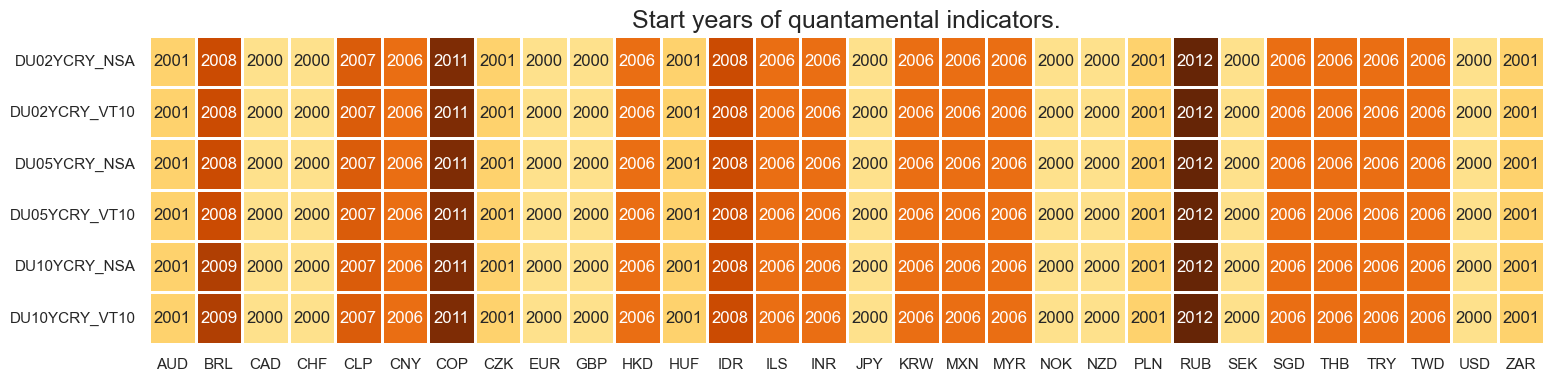

Last updated: 2025-03-20


In [6]:
xcatx = main
cidx = cids_exp

dfa = msm.reduce_df(df, xcats=xcatx, cids=cidx)
dfs = msm.check_startyears(
    dfa,
)
msm.visual_paneldates(dfs, size=(18, 4))

print("Last updated:", date.today())

In [7]:
dfb = df[df["xcat"].isin(["FXTARGETED_NSA", "FXUNTRADABLE_NSA"])].loc[
    :, ["cid", "xcat", "real_date", "value"]
]
dfba = (
    dfb.groupby(["cid", "real_date"])
    .aggregate(value=pd.NamedAgg(column="value", aggfunc="max"))
    .reset_index()
)
dfba["xcat"] = "FXBLACK"
fxblack = msp.make_blacklist(dfba, "FXBLACK")

In [8]:
current_date = pd.Timestamp('now').strftime('%Y-%m-%d')
try_na = ["2020-02-24", "2024-08-01"]
black = {"TRY": try_na}  # Restricted Tradability of Russia
df = msm.reduce_df(df, blacklist=black).reset_index(drop=True)

# History

## 2-year duration carry

Duration carry has predominantly been positive but the standard deviations have been large relative to the absolute averages. Standard deviations have typically exceeded absolute carry averages, particularly for higher-yield emerging markets..

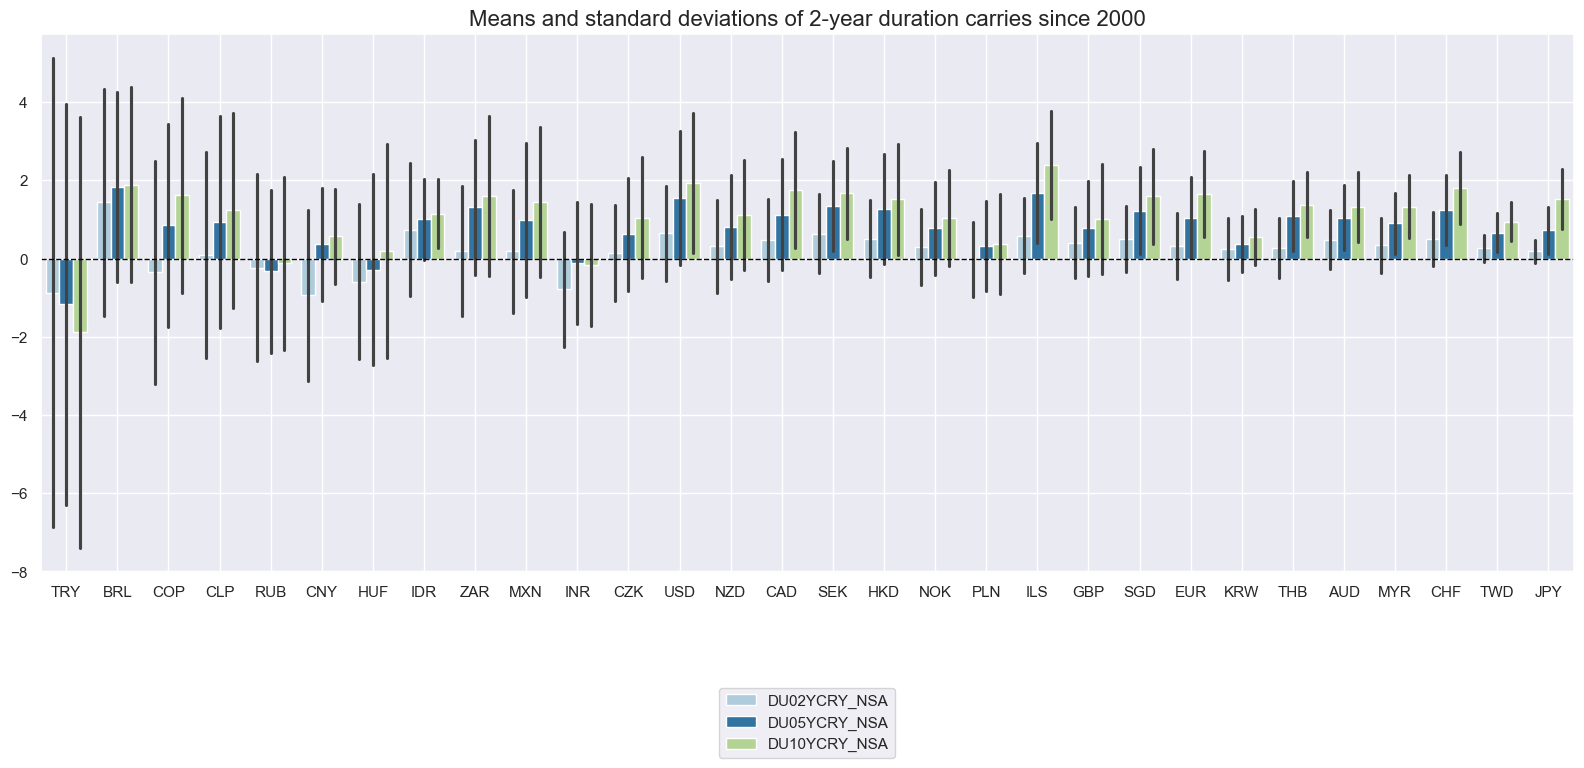

In [9]:
xcatx = ["DU02YCRY_NSA", "DU05YCRY_NSA", "DU10YCRY_NSA"]
cidx = cids_exp

msp.view_ranges(
    df,
    xcats=xcatx,
    cids=cidx,
    sort_cids_by="std",
    start="2000-01-01",
    title="Means and standard deviations of 2-year duration carries since 2000",
    kind="bar",
    size=(16, 8),
)

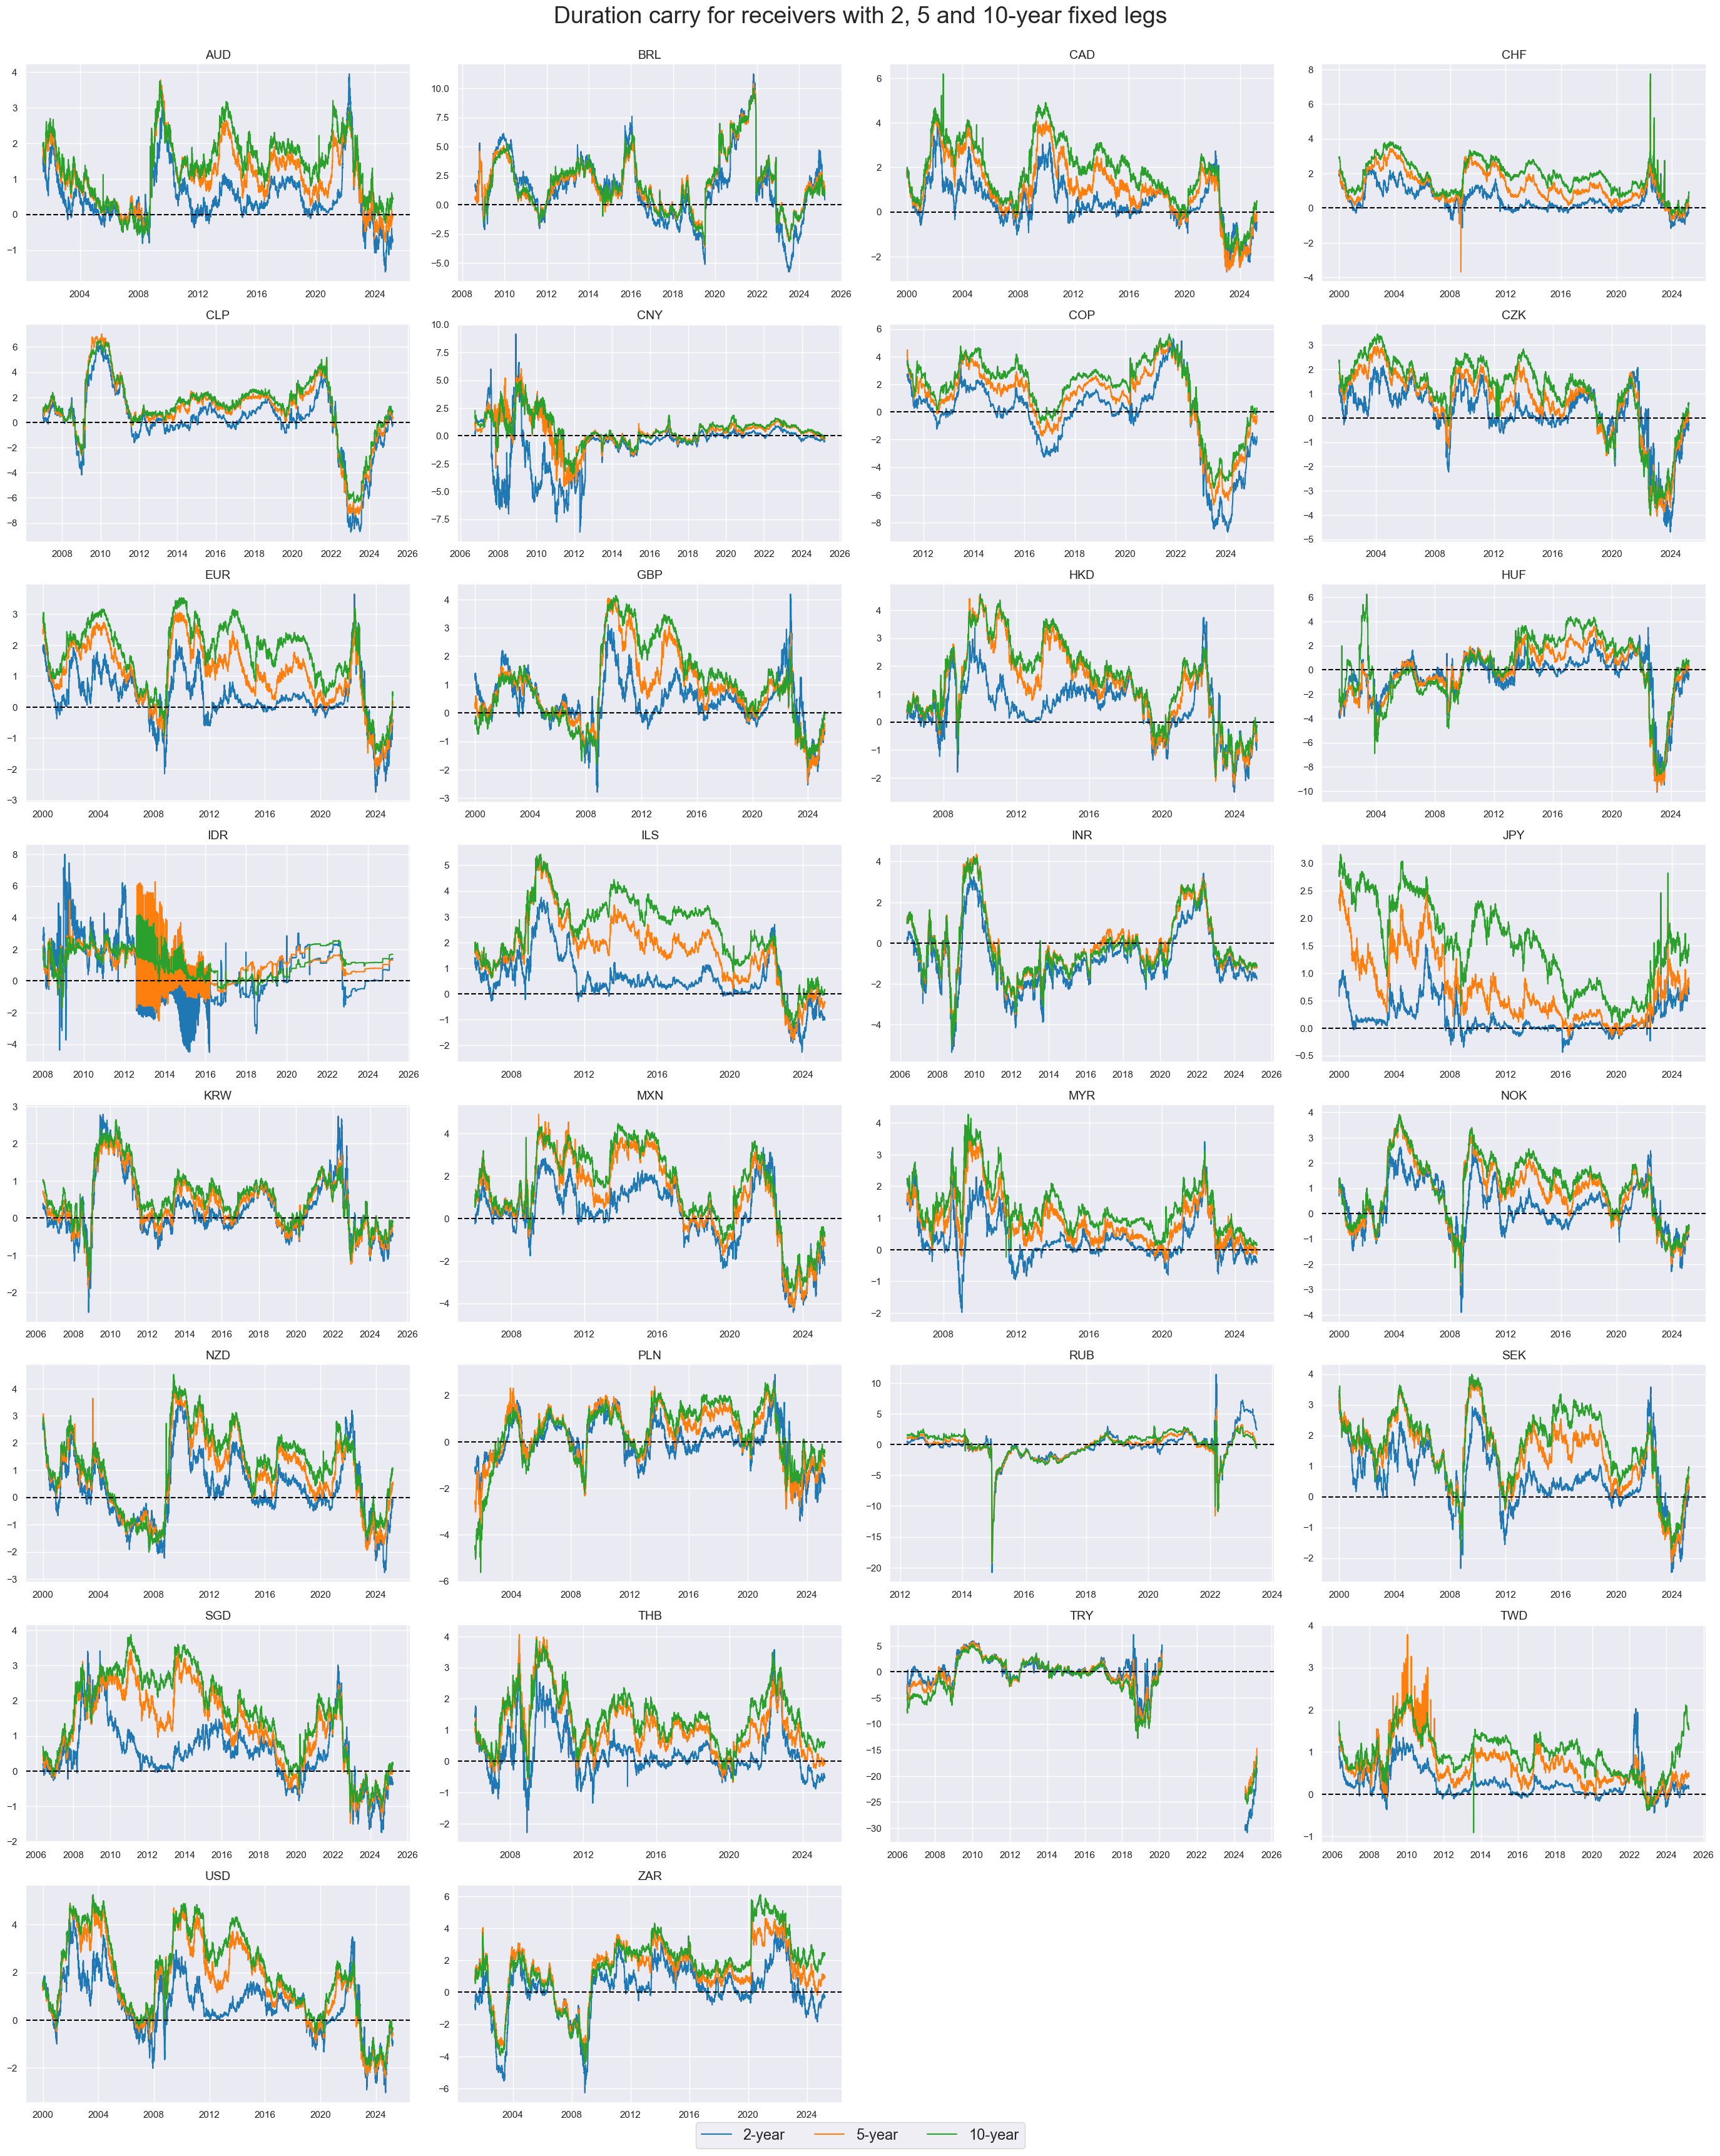

In [10]:
xcatx = ["DU02YCRY_NSA", "DU05YCRY_NSA", "DU10YCRY_NSA"]
cidx = cids_exp

msp.view_timelines(
    df,
    xcats=xcatx,
    cids=cidx,
    start="2000-01-01",
    title="Duration carry for receivers with 2, 5 and 10-year fixed legs",
    title_fontsize=27,
    legend_fontsize=17,
    cumsum=False,
    ncol=4,
    same_y=False,
    size=(12, 7),
    xcat_labels= ["2-year", "5-year", "10-year"], 
    all_xticks=True,
)

For most countries, cross-sectional correlations of short-term carry have been positive over the last 20 years. However China, Hungary, Indonesia and Russia have displayed pronounced idiosyncratic fluctuations.

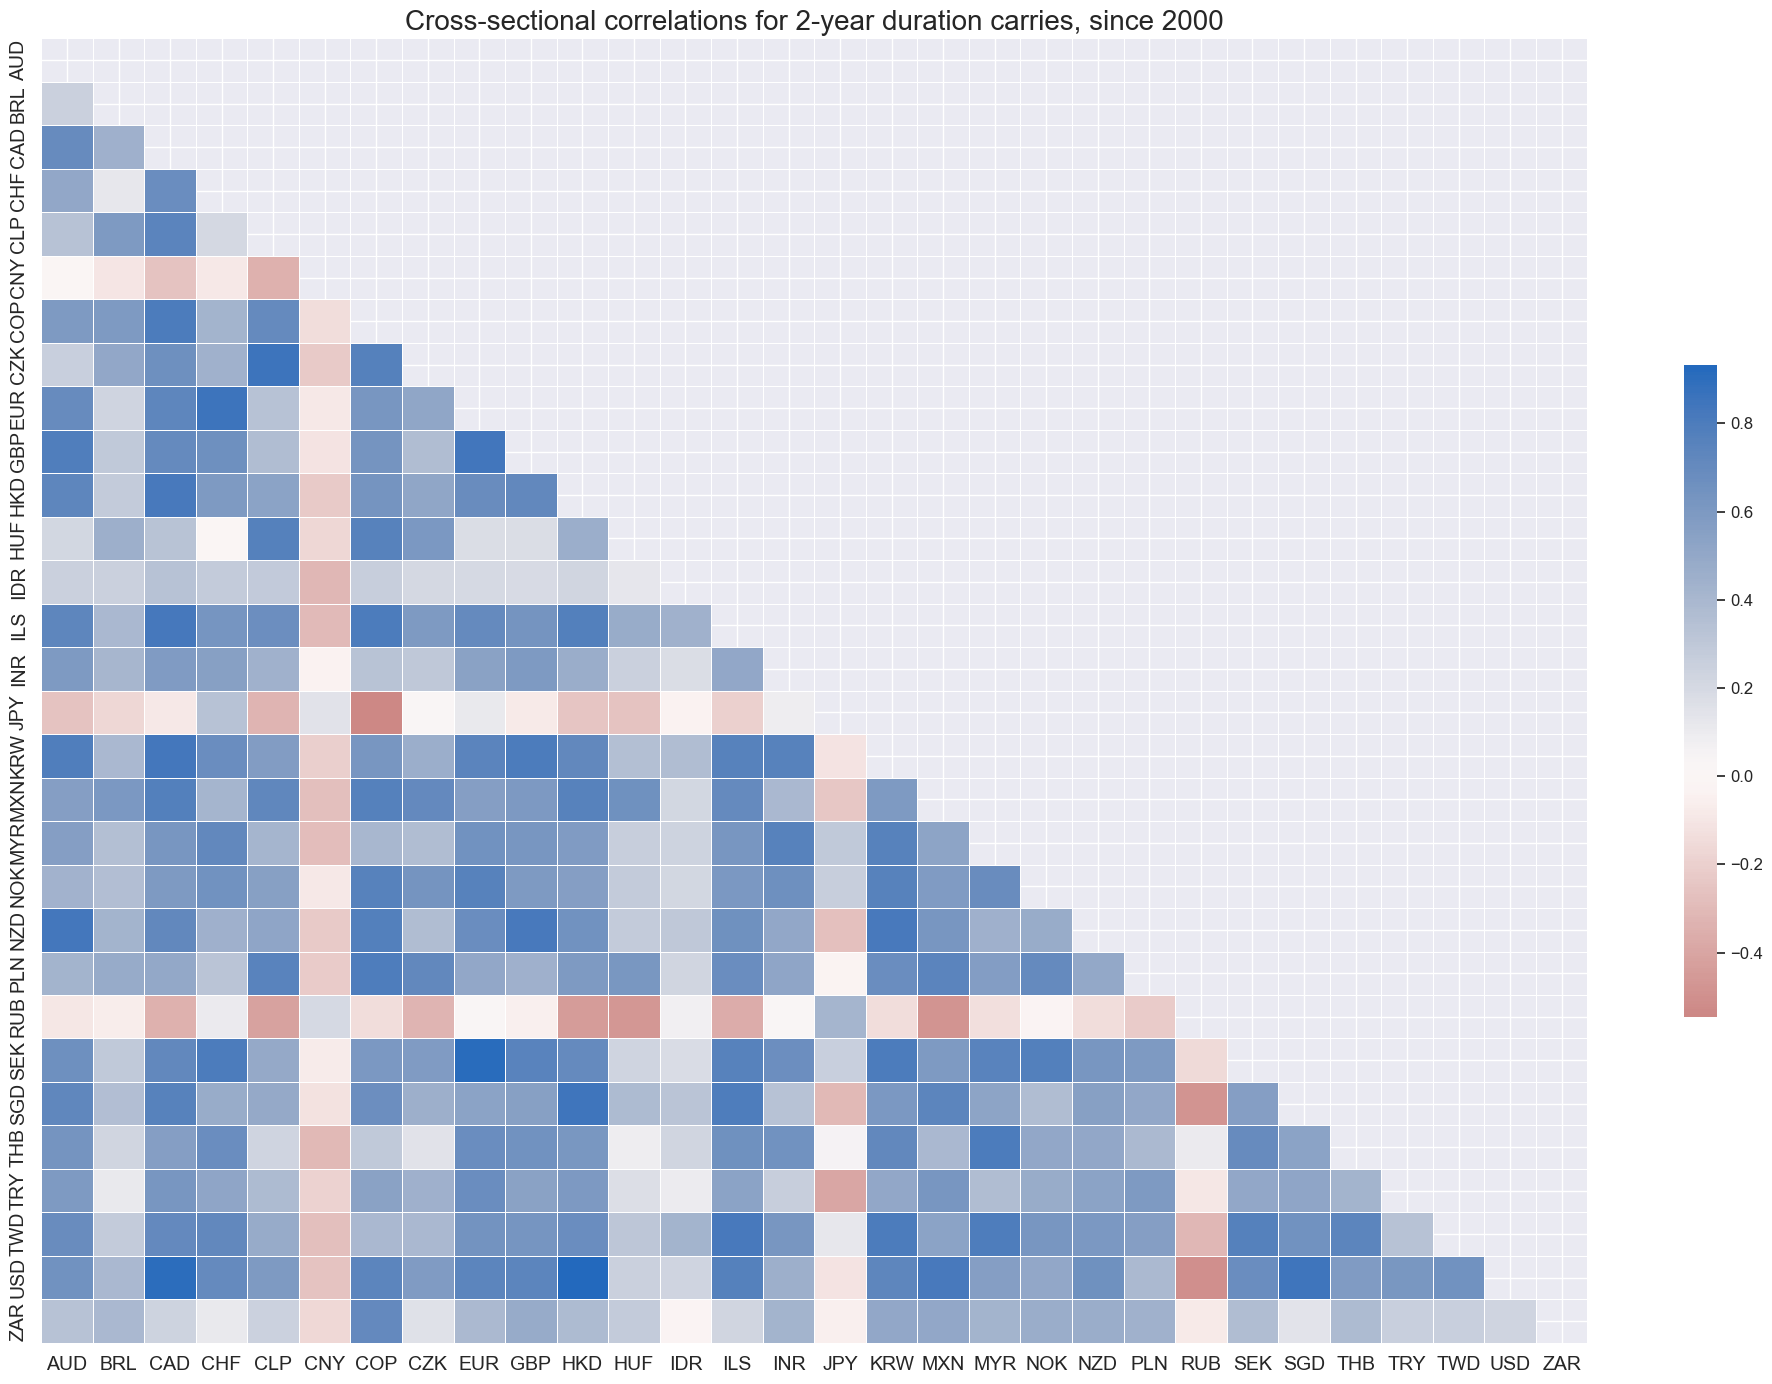

In [11]:
xcatx = "DU02YCRY_NSA"
cidx = cids_exp

msp.correl_matrix(
    df,
    xcats=xcatx,
    cids=cidx,
    title="Cross-sectional correlations for 2-year duration carries, since 2000",
    size=(20, 14),
)

## Vol-targeted duration carry

Duration carry for 10% annualized volatility targets has been predominantly positive and ranged from a negative 50 basis points to a positive 100 basis points.

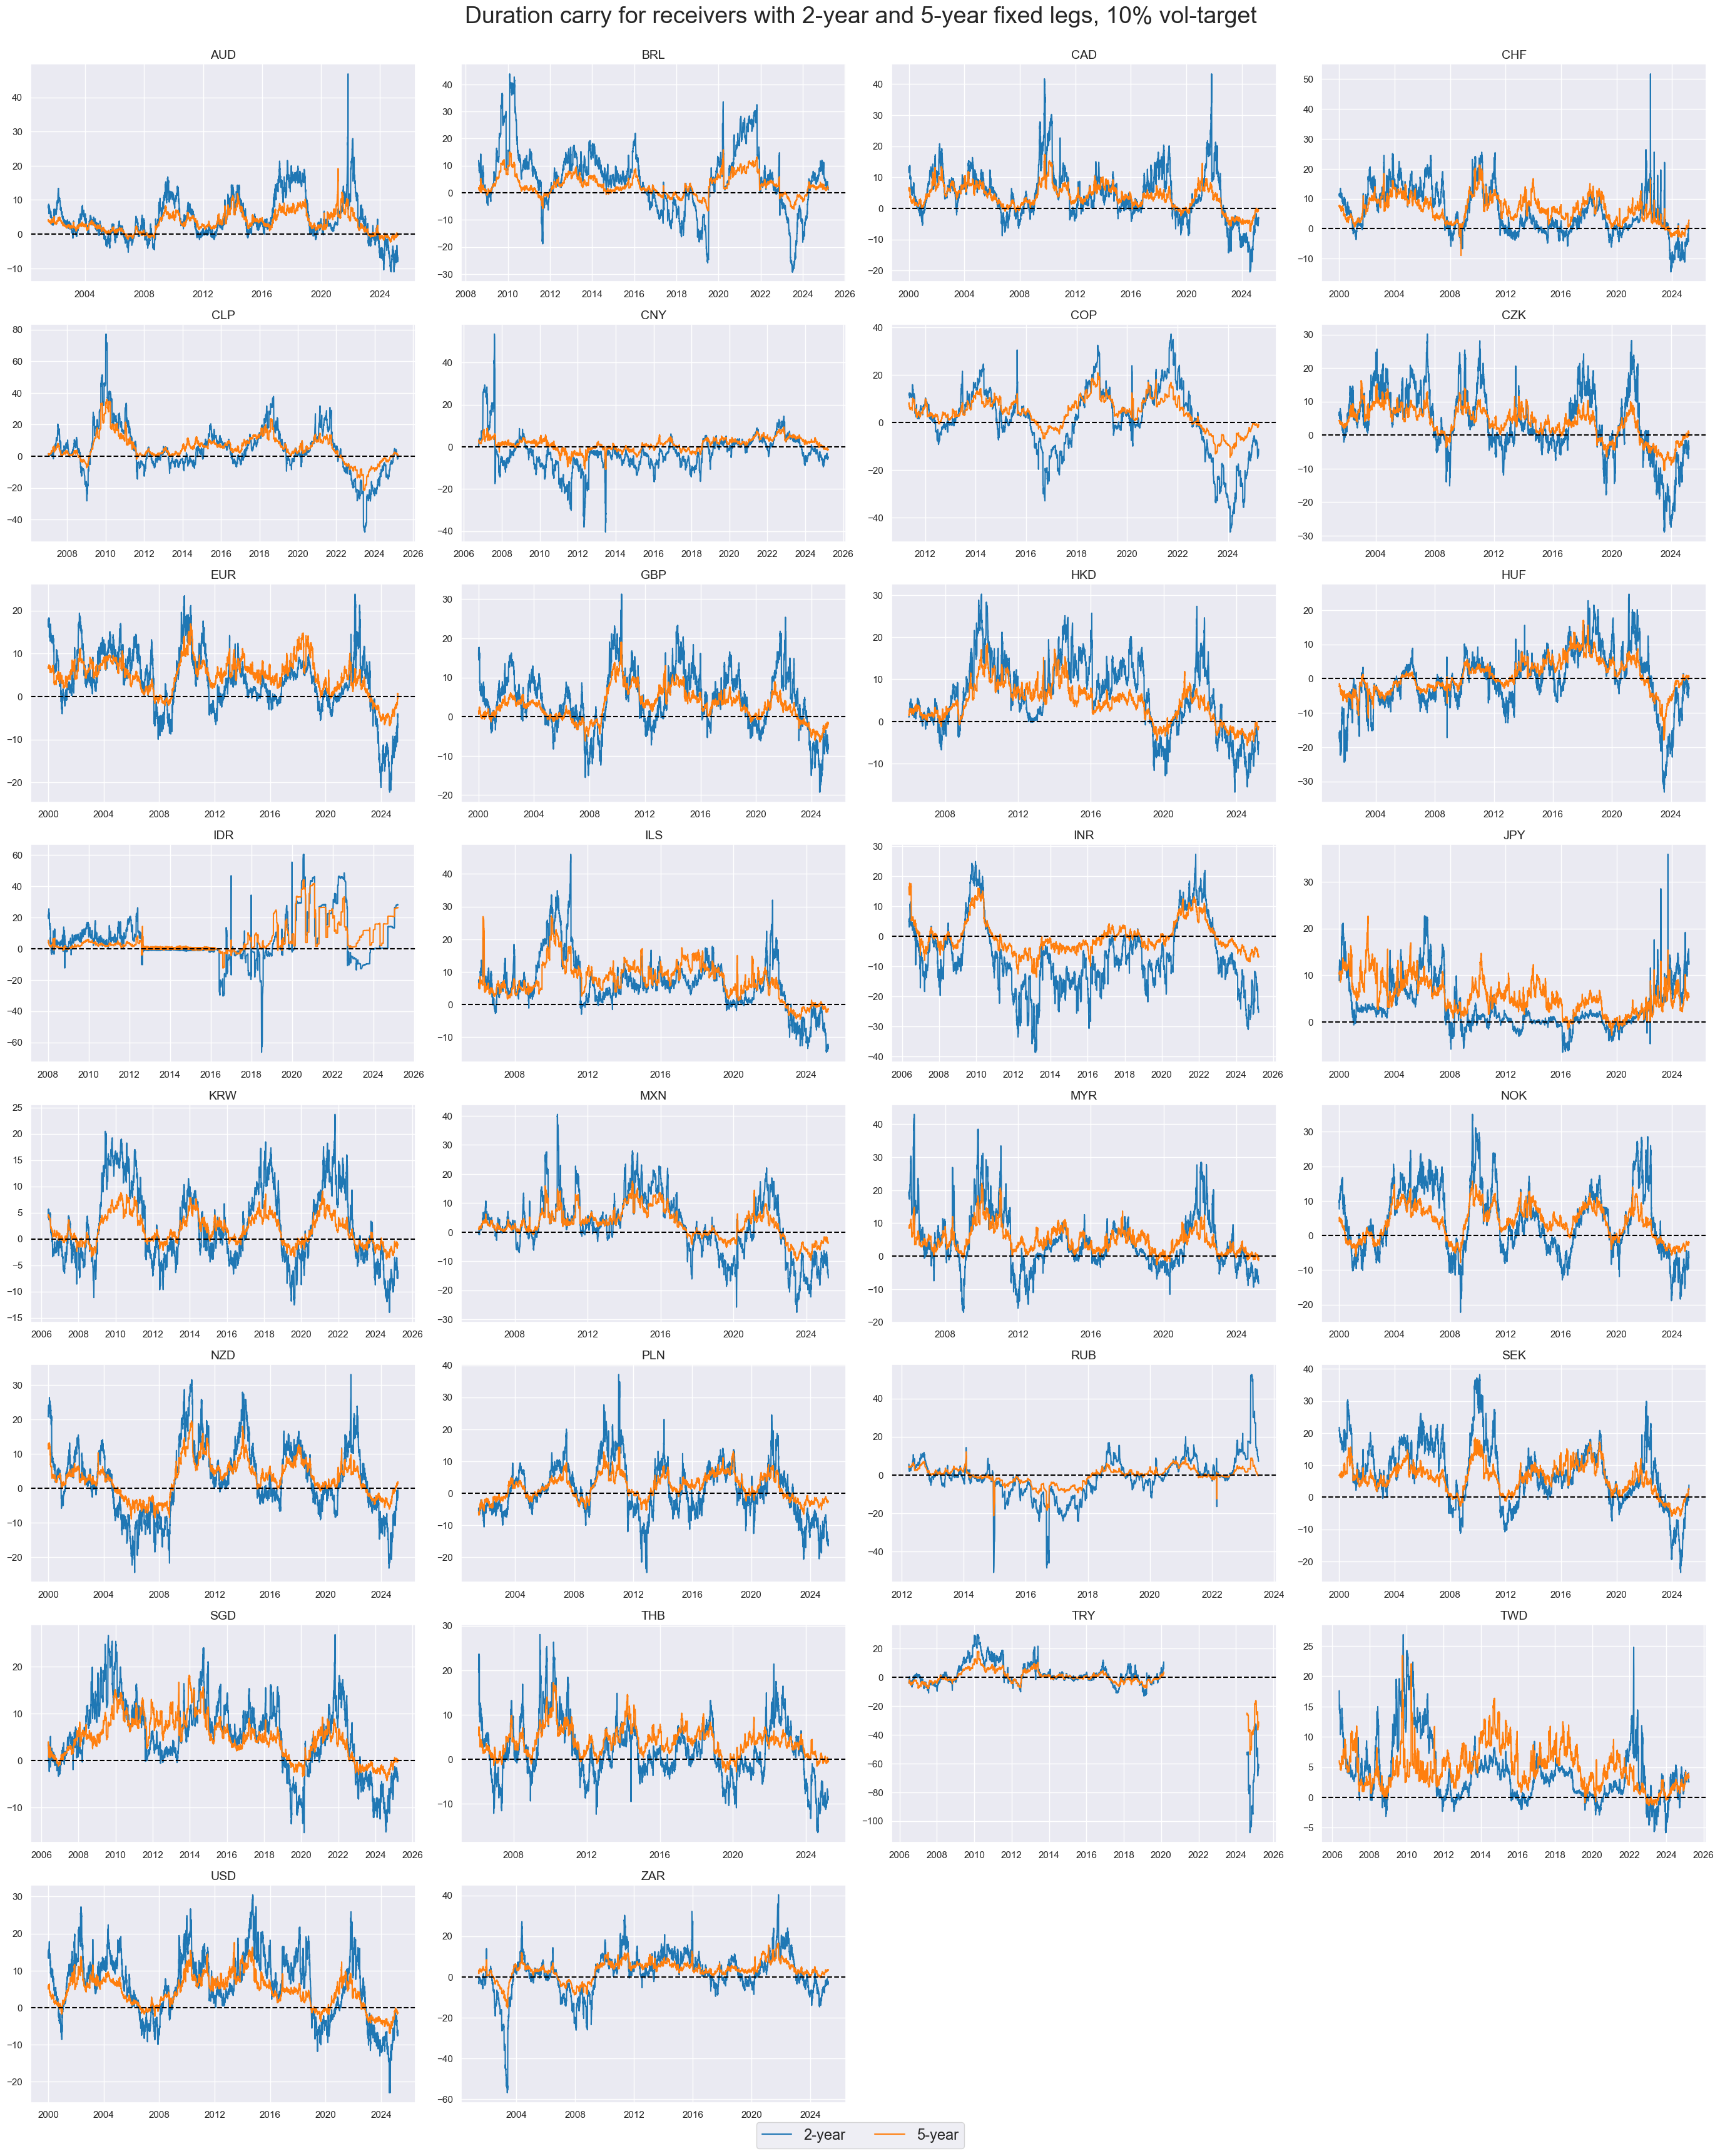

In [12]:
xcatx = ["DU02YCRY_VT10", "DU05YCRY_VT10"]
msp.view_timelines(
    df,
    xcats=xcatx,
    cids=cidx,
    start="2000-01-01",
    title="Duration carry for receivers with 2-year and 5-year fixed legs, 10% vol-target",
    title_fontsize=27,
    legend_fontsize=17,
    xcat_labels=["2-year", "5-year"],
    cumsum=False,
    ncol=4,
    same_y=False,
    size=(12, 7),
    all_xticks=True,
)

# Importance

## Research Links

"Empirical evidence for 27 markets suggests that carry on interest rate swaps has been positively correlated with subsequent returns for the past two decades. Indeed, a naïve strategy following carry as signal has produced respectable risk-adjusted returns. However, this positive past performance masks the fundamental flaw of the carry signal: it disregards the expected future drift in interest rates and favours receiver position in markets with very low real rates. In the 2000s and 2010s this oversight mattered little because inflation and yields drifted broadly lower. If the inflation cycle turns or just stabilizes, however, short-term rates normalization should become very consequential. Indeed, enhancing the IRS carry signal by a plausible medium term drift in short rates has already in the past produced more stable returns and more convincing actual 'alpha'." [Macrosynergy](https://research.macrosynergy.com/fixed-income-carry-as-a-trading-signal/)

"We find that carry is a strong positive predictor of returns in each of the major asset classes we study, in both the cross section and the time series." [Koijen, Moskowitz, Pedersen & Vrugt](https://www.sciencedirect.com/science/article/pii/S0304405X17302908)

"The robust performance of carry strategies across asset classes ... indicates that carry is an important component of expected returns... we find that a carry strategy works at least as well in other asset classes [as in currencies], too, performing markedly better in equities and put options than in currencies, and performing about as well as currencies in commodities, global fixed income, and Treasuries. Hence, carry is a broader concept that can be applied to many assets in general and is not unique to currencies." [Koijen, Moskowitz, Pedersen & Vrugt](https://www.sciencedirect.com/science/article/pii/S0304405X17302908)



## Empirical Clues

### Duration carry and subsequent IRS returns

Duration carry has been positively correlated with subsequent returns both intertemporally and across currency areas. Predictive relations can be found for simple and vol-targeted positions and at weekly, monthly, and quarterly frequencies. For most case the relation has been statistically significant and robust across time since 2000.

In [13]:
dfx = df.copy()

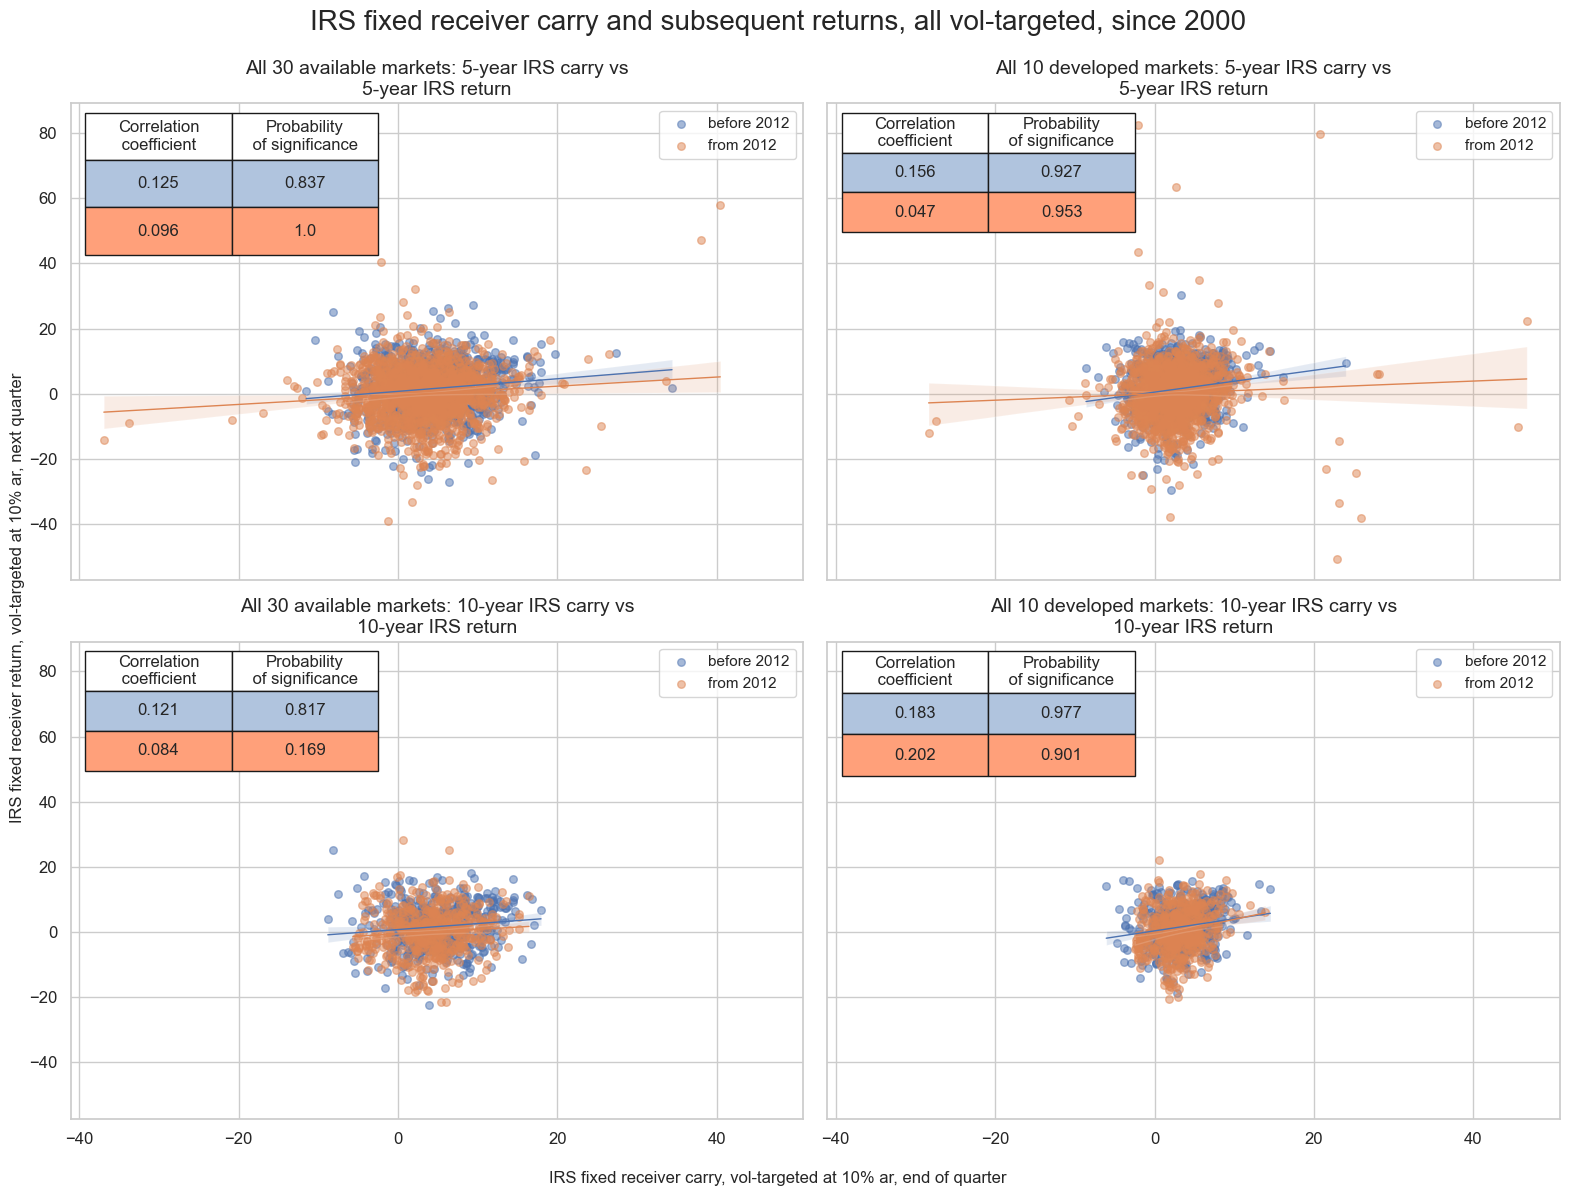

In [14]:
# Signals and targets

sigx_irs = {"DU05YCRY_VT10": "5-year IRS carry",
            "DU10YCRY_VT10": "10-year IRS carry",}

targx_irs = {"DU05YXR_VT10": "5-year IRS return",
             "DU10YXR_VT10": "10-year IRS return"}


cidx_dict_irs = {
    f"All {len(set(cids_exp))} available markets": list(set(cids_exp)),
    f"All {len(set(cids_dmca))} developed markets": list(set(cids_dmca) )
}

# Iterate through the mapped signals:
cr = {}

selected_pairs = [
    ("DU05YCRY_VT10", "DU05YXR_VT10"),
    ("DU10YCRY_VT10", "DU10YXR_VT10")
]

for cid_name, cid_list in cidx_dict_irs.items():
    for sig_key, targ_key in selected_pairs:
        cr[f"cr_{cid_name}_{sig_key}_{targ_key}"] = msp.CategoryRelations(
            dfx,
            xcats=[sig_key, targ_key],
            cids=cid_list,
            freq="Q",
            lag=1,
            xcat_aggs=["last", "sum"],
            start="2000-01-01",
        )

all_cr_instances = list(cr.values())

# Subplot titles
subplot_titles = [
    f"{cid_name}: {sigx_irs[sig_key]} vs {targx_irs[targ_key]}"
    for sig_key, targ_key in [
        ("DU05YCRY_VT10", "DU05YXR_VT10"),
        ("DU10YCRY_VT10", "DU10YXR_VT10")
    ]
    for cid_name in cidx_dict_irs.keys()  # Ensure markets are iterated inside signals loop
]

# Facet of plots

msv.multiple_reg_scatter(
        all_cr_instances,
        title=f"IRS fixed receiver carry and subsequent returns, all vol-targeted, since 2000" ,
        xlab="IRS fixed receiver carry, vol-targeted at 10% ar, end of quarter",
        ylab="IRS fixed receiver return, vol-targeted at 10% ar, next quarter",
        separator=2012,
        ncol=2,
        nrow=2,
        figsize=(16, 12),
        prob_est="map",
        subplot_titles = subplot_titles,
        coef_box="upper left",
)

The positive intertemporal carry-return relationship has held for all developed markets and for both the 5-year and 10-year tenors.

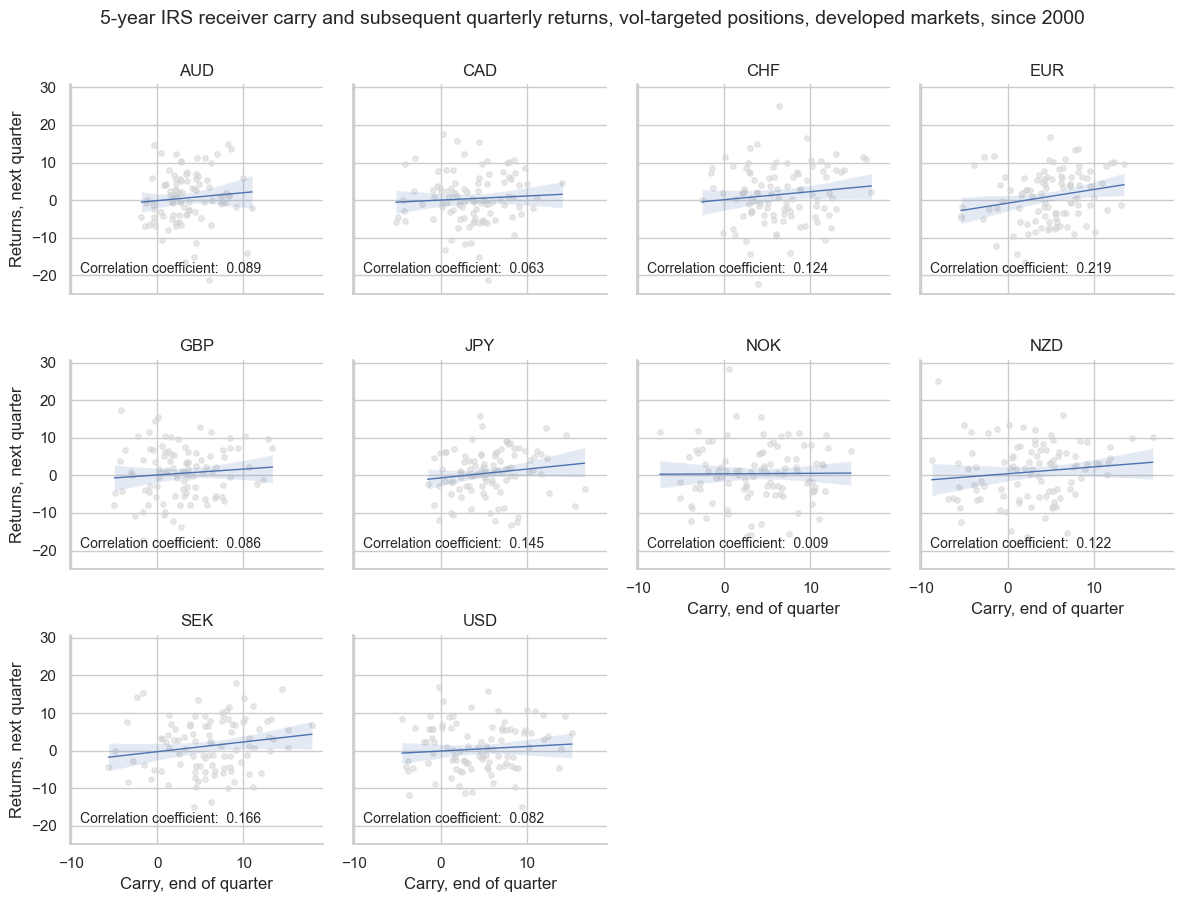

In [15]:
cid_name = f"All {len(set(cids_dmca))} developed markets"
sig_key = "DU05YCRY_VT10"
targ_key = "DU05YXR_VT10"

# Access the specific cr instance
cr[f"cr_{cid_name}_{sig_key}_{targ_key}"].reg_scatter(
    title="5-year IRS receiver carry and subsequent quarterly returns, vol-targeted positions, developed markets, since 2000",
    labels=True,
    coef_box="lower right",
    separator="cids",
    xlab="Carry, end of quarter",
    ylab="Returns, next quarter",
)

### Duration carry and subsequent government bond returns

IRS carry has also predicted government bond returns positively and significantly across 5 developed markets with their own currency.

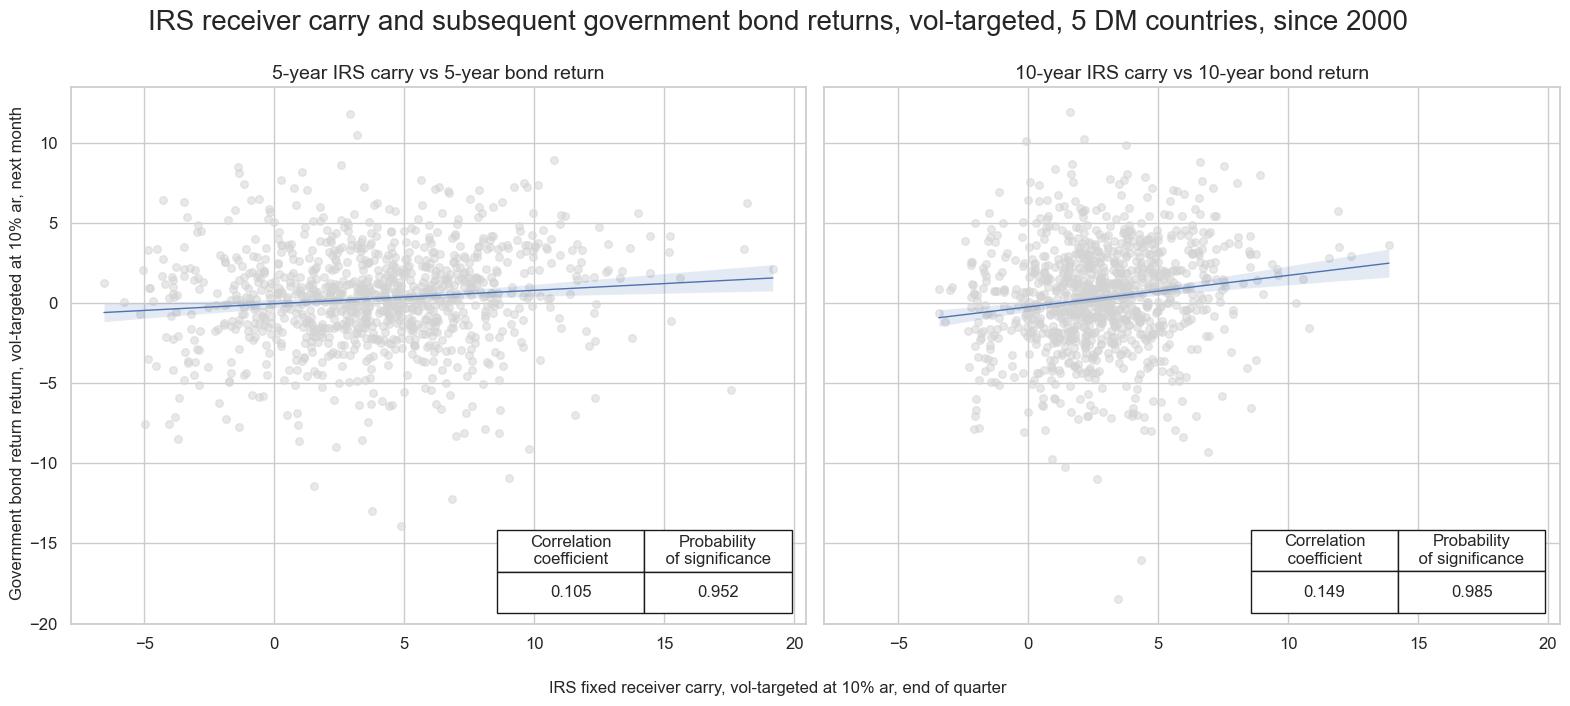

In [16]:
# specify the signals and targets for the analysis

sigx_irs = {"DU05YCRY_VT10": "5-year IRS carry",
            "DU10YCRY_VT10": "10-year IRS carry",}

targx_bond = {"GB05YXR_VT10": "5-year bond return",
             "GB10YXR_VT10": "10-year bond return"
           }


cidx_bonds = msm.common_cids(dfx, xcats=list(sigx_irs.keys()) + list(targx_bond.keys()))

# Iterate through the mapped signals:
cr = {}

selected_pairs = [
    ("DU05YCRY_VT10", "GB05YXR_VT10"),
    ("DU10YCRY_VT10", "GB10YXR_VT10")
]

for sig_key, targ_key in selected_pairs:
        cr[f"cr_{sig_key}_{targ_key}"] = msp.CategoryRelations(
            dfx,
            xcats=[sig_key, targ_key],
            cids=cidx_bonds,
            freq="M",
            lag=1,
            xcat_aggs=["last", "sum"],
            start="2000-01-01",
        )

all_cr_instances = list(cr.values())

# create subplot titles based on identifiers and market types
subplot_titles = [
    f"{sigx_irs[sig_key]} vs {targx_bond[targ_key]}"
    for sig_key, targ_key in [
         ("DU05YCRY_VT10", "GB05YXR_VT10"),
         ("DU10YCRY_VT10", "GB10YXR_VT10")
    ]
]  


# plot side by side all the CategoryRelations instances
msv.multiple_reg_scatter(
        all_cr_instances,
        title=f"IRS receiver carry and subsequent government bond returns, vol-targeted, {len(cidx_bonds)} DM countries, since 2000" ,
        xlab="IRS fixed receiver carry, vol-targeted at 10% ar, end of quarter",
        ylab="Government bond return return, vol-targeted at 10% ar, next month",
        ncol=2,
        nrow=1,
        figsize=(16, 7),
        prob_est="map",
        subplot_titles = subplot_titles,
        coef_box="lower right",
)

### Duration carry trend and subsequent duration returns

We define two medium-term trend measures

-   Week versus year trend: This is the difference between the duration carry in the latest week (5 trading days) and the previous year (252 trading days).
-   Month versus two-years trend: This is the difference between the duration carry in the latest month (21 trading days) and the previous 2 years (504 trading days).

In [17]:
cidx = cids
calcs = [
    "DU05YCRY_NSA_5Dv252D = DU05YCRY_NSA.rolling(5).mean() - DU05YCRY_NSA.shift(5).rolling(252).mean()",
    "DU10YCRY_NSA_21Dv504D = DU10YCRY_NSA.rolling(21).mean() - DU10YCRY_NSA.shift(21).rolling(504).mean()",
    ]
dfa = msp.panel_calculator(dfx, calcs=calcs, cids=cidx)
dfx = msm.update_df(dfx, dfa)

Both medium-term trends have been positively and significantly correlated with subsequent IRS receiver returns, for vol-targeted or outright positions.

DU05YCRY_NSA_5Dv252D misses: ['PEN', 'PHP'].
DU05YXR_NSA misses: ['PEN', 'PHP'].
DU10YCRY_NSA_21Dv504D misses: ['PEN', 'PHP'].
DU10YXR_NSA misses: ['PEN', 'PHP'].


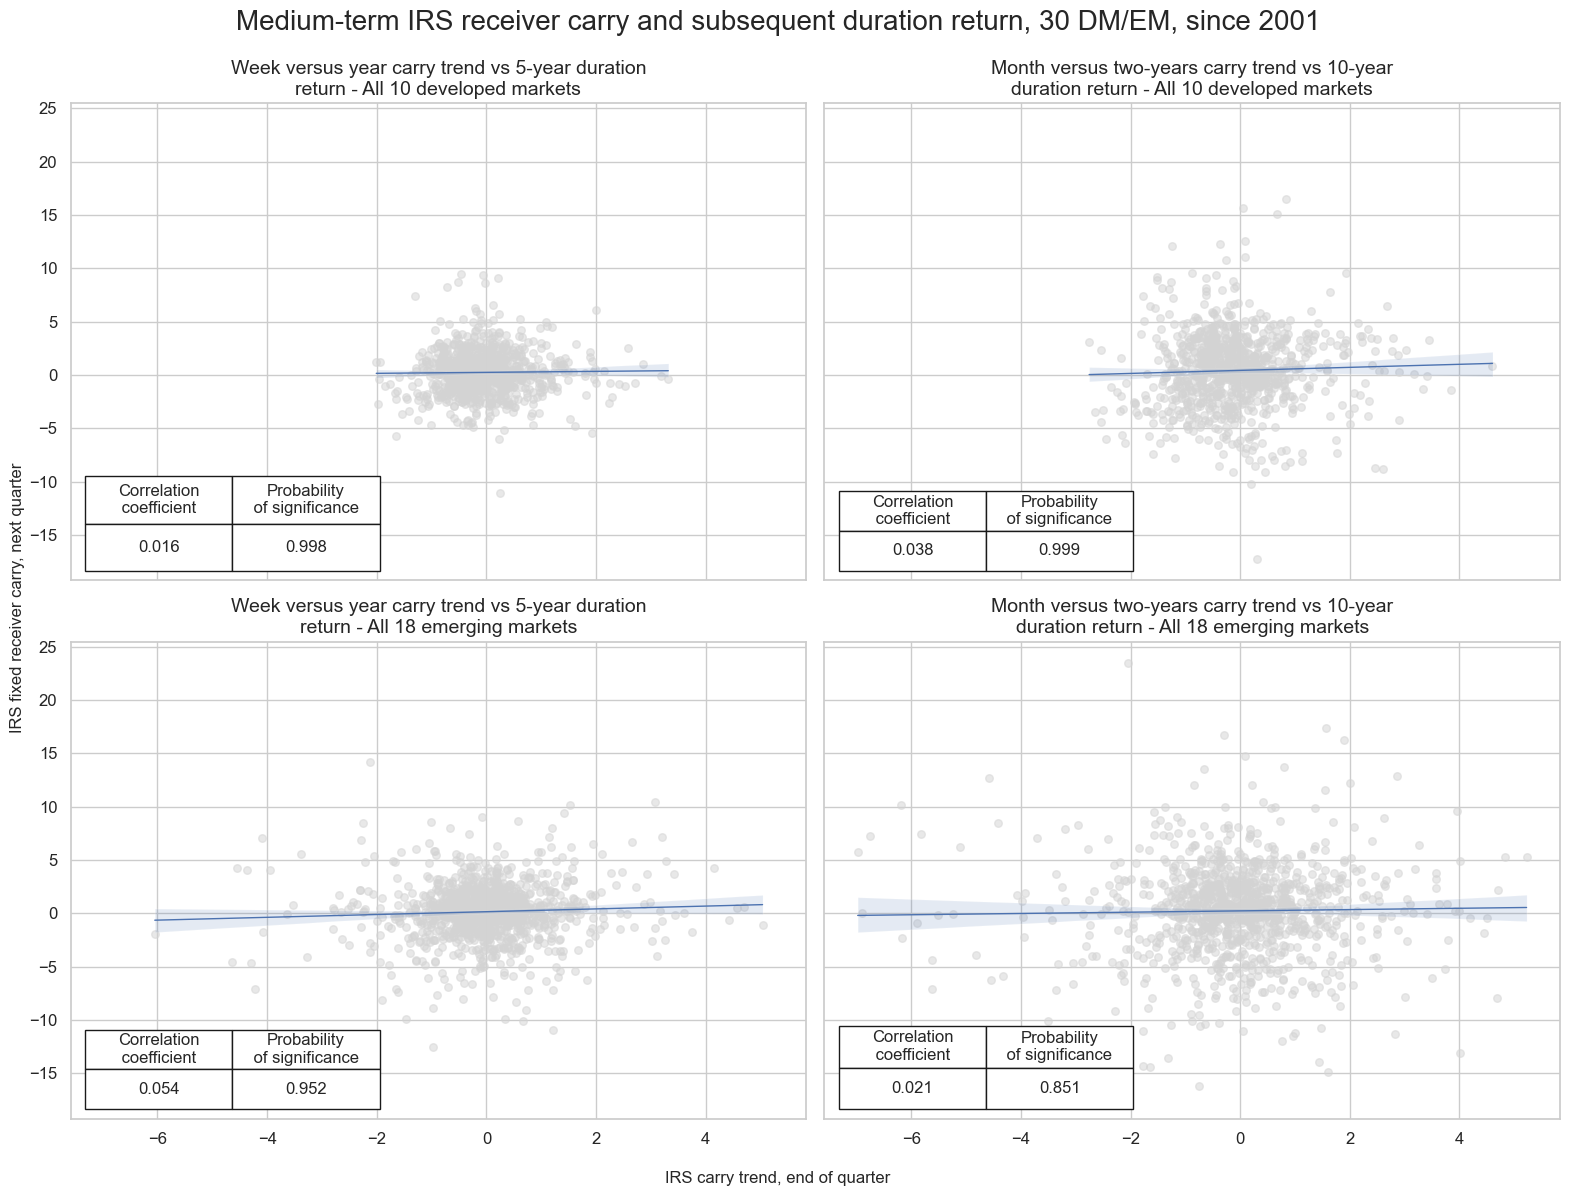

In [18]:
# Define signal and target mappings
sigx_trend = {
    "DU05YCRY_NSA_5Dv252D": "Week versus year carry trend",
    "DU10YCRY_NSA_21Dv504D": "Month versus two-years carry trend",
}

targx_trend = {
    "DU05YXR_NSA": "5-year duration return",
    "DU10YXR_NSA": "10-year duration return",
}

# Define cross-section (market) groups
cidx_dict_trend = {
    f"All {len(set(cids_dmca))} developed markets": list(set(cids_dmca)),
     f"All {len(set(cids_emx))} emerging markets": list(set(cids_emx)),
     }

# Define target-signal mapping for iteration
selected_pairs = [
    ("DU05YCRY_NSA_5Dv252D", "DU05YXR_NSA"),  # Emerging markets
    ("DU10YCRY_NSA_21Dv504D", "DU10YXR_NSA"),  # Developed markets
]

# Dictionary to store CategoryRelations objects
cr = {}

# Iterate through markets and matched signals/targets
for cid_name, cid_list in cidx_dict_trend.items():
    for sig_key, targ_key in selected_pairs:
        # Construct dictionary key for storing results
        cr[f"cr_{cid_name}_{sig_key}_{targ_key}"] = msp.CategoryRelations(
            dfx,
            xcats=[sig_key, targ_key],  # Assign correct signals & targets
            cids=cid_list,  # Use the corresponding cross-sections
            freq="Q",  # Quarterly frequency
            lag=1,
            xcat_aggs=["last", "sum"],
            # blacklist=fxblack,  # Uncomment if needed
            start="2000-01-01",
        )

# Store all CategoryRelations instances in a list
all_cr_instances = list(cr.values())

subplot_titles = [
    f"{sigx_trend[sig]} vs {targx_trend[targ]} - {cid_name}"
    for cid_name, cid_list in cidx_dict_trend.items()  # Iterate over market groups
    for sig, targ in selected_pairs  # Iterate over signal-target pairs
    if sig in sigx_trend and targ in targx_trend  # Ensure valid keys
]

# plot side by side all the CategoryRelations instances
msv.multiple_reg_scatter(
        all_cr_instances,
        title=f"Medium-term IRS receiver carry and subsequent duration return, {len(cids_exp)} DM/EM, since 2001" ,
        xlab="IRS carry trend, end of quarter",
        ylab="IRS fixed receiver carry, next quarter",
        ncol=2,
        nrow=2,
        figsize=(16, 12),
        prob_est="map",
        subplot_titles = subplot_titles,
        coef_box="lower left",
)

### Duration carry correlation with other carry types

Interest rate swap carry is positively correlated with both government bond and equity carry, while it has a negative correlation with FX carry and duration return volatility.

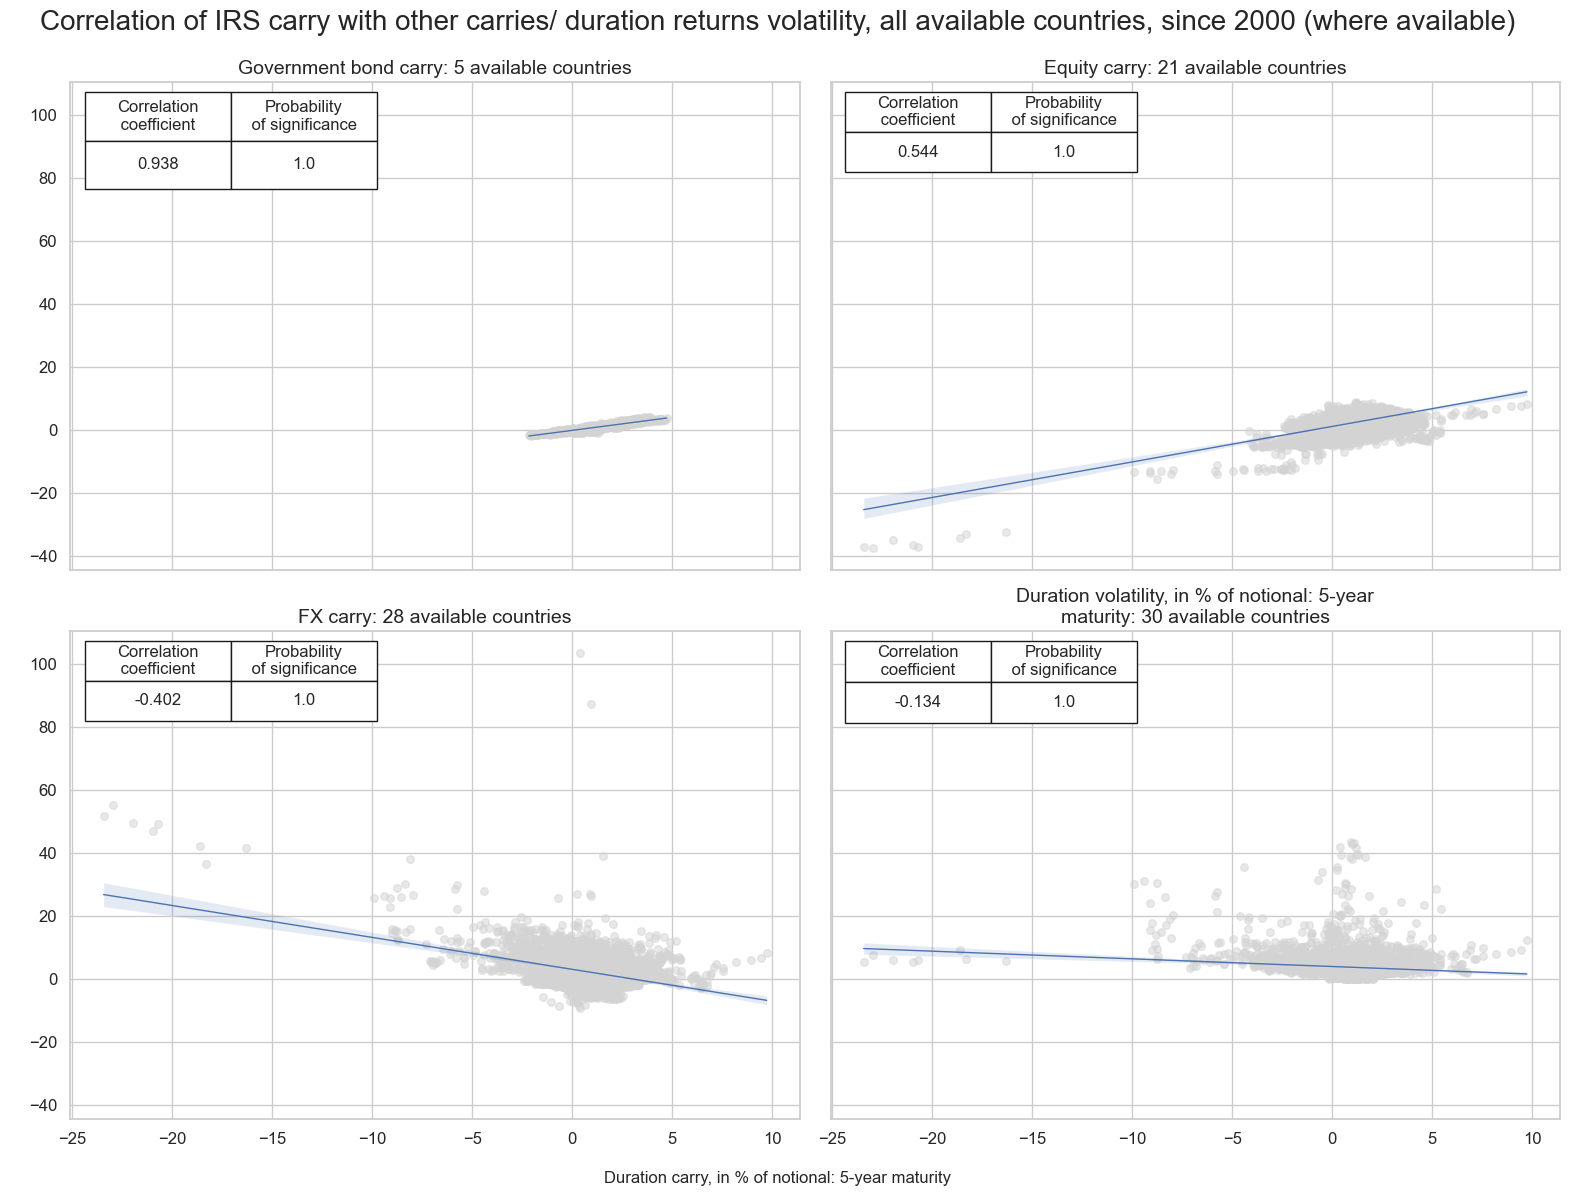

In [19]:


targx_dict = {
    "GB05YCRY_NSA": "Government bond carry",
    "EQCRY_NSA": "Equity carry",
    "FXCRY_NSA": "FX carry",
    "DU05YXRxEASD_NSA": "Duration volatility, in % of notional: 5-year maturity", 
}

sigx = {"DU05YCRY_NSA": "5-year interest rate swap carry"}

# Dictionary for storing CategoryRelations objects and length of cids
cr = {}
cids_lengths = {}

# Iterate through the mapped signals:
for targ in targx_dict.keys():
    xcats = list(sigx.keys()) + [targ]  # Ensure correct format for xcats

    # ✅ Compute `cidx` dynamically for each `targ`
    cidx = msm.common_cids(dfx, xcats=xcats)
    cids_lengths[targ] = len(set(cidx))
  
    # ✅ Create a unique CategoryRelations instance for each `targ`
    
    cr[f"cr_{targ}"] = msp.CategoryRelations(
        dfx,
        xcats=xcats,
        cids=cidx,  # Now dynamically updated for each target
        freq="M",  # Correct capitalization for monthly
        lag=0,
        xcat_aggs=["mean", "mean"],
        blacklist=fxblack,
        start="2000-01-01",
    )

# ✅ Combine all CategoryRelations instances for plotting
all_cr_instances = list(cr.values())


subplot_titles = [
    f"{lab}: {cid} available countries"
    for lab, cid in zip(targx_dict.values(), cids_lengths.values())
]


# plot side by side all the CategoryRelations instances
msv.multiple_reg_scatter(
        all_cr_instances,
        title="Correlation of IRS carry with other carries/ duration returns volatility, all available countries, since 2000 (where available)" ,
        xlab="Duration carry, in % of notional: 5-year maturity",
        ylab="  ",
        ncol=2,
        nrow=2,
        figsize=(16, 12),
        prob_est="map",
        subplot_titles = subplot_titles,
        coef_box="upper left",
)

# Appendices

## Appendix 1: Calculations 

<a id='appendix1'></a>
Given an arbitrary day $t$ and tenor $h$, the basic formula for the 'duration' carry on a fixed receiver position in the main interest rate swap contract traded in the respective currency area is

$ \text{DU\{h\}CRY\_NSA}(t) = y_{\text{fix}}(t, h) - y_{\text{float}}(t) - \text{DUR}(t, h) \times \left[ y_{\text{fix}}(t, h-1) - y_{\text{fix}}(t, h) \right] $

where 

* $y_{\text{float}}(t,h)$ is the floating interest rate
* $y_{\text{fix}}(t,h)$ is the daily fixing of the contract
* $\text{DUR}(t, h)$ is the duration of the underlying contract.

## Appendix 2: Currency symbols

<a id='appendix2'></a>
The word 'cross-section' refers to currencies, currency areas or economic areas. In alphabetical order, these are
AUD (Australian dollar), BRL (Brazilian real), CAD (Canadian dollar), CHF (Swiss franc), CLP (Chilean peso), CNY (Chinese yuan renminbi), COP (Colombian peso), CZK (Czech Republic koruna), DEM (German mark), ESP (Spanish peseta), EUR (Euro), FRF (French franc), GBP (British pound), HKD (Hong Kong dollar), HUF (Hungarian forint), IDR (Indonesian rupiah), ITL (Italian lira), JPY (Japanese yen), KRW (Korean won), MXN (Mexican peso), MYR (Malaysian ringgit), NLG (Dutch guilder), NOK (Norwegian krone), NZD (New Zealand dollar), PEN (Peruvian sol), PHP (Phillipine peso), PLN (Polish zloty), RON (Romanian leu), RUB (Russian ruble), SEK (Swedish krona), SGD (Singaporean dollar), THB (Thai baht), TRY (Turkish lira), TWD (Taiwanese dollar), USD (U.S. dollar), ZAR (South African rand).